## Thoughts
### Simplify the network
- Number of people on the airplane
- If a node has two egdes to the same node, we can merge them into one
- Cut off dead ends (Airports with no return)
- Merge airports that go from the same City. Example: JFK and NLI Airport
- Should airports have a certain amount of flights between airports before they are relevant?
- How many people does the average plane seat? Should we assume that planes with a shorter flight have fewer passengers and planes with a longer flight have more passengers.
- How often does a plane fly?

### How should the disease spread
- The number of airplanes leaving the airport should be equal to number of iterations for the specific airport.
- Probability for an infected person to travel with an airplane
- How much does the disease spread? For example, about 1/10 people in contact with the infected person gets the disease.




## Brief network description

We are working with an openflights airport network from icon.colorado.edu. which is a weighted, directed, multigraph, network where the nodes represent airports worldwide and the direction of edge {i,j} indicates a regularly occurring commercial flight, by a particular airline from airport i to airport j. Multiple edges may exist between pairs of airports if multiple airlines offer that flight, or if one airline offers multiple such flights each day. The  number of nodes is: 3214 and the  number of edges is: 18859.
https://networks.skewed.de/net/openflights


In [ ]:
!pip install networkx

## Imports and Reading in our data

In [ ]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import collections
from collections import Counter

In [ ]:
nodes = '../network/nodes.csv'
edges = "../network/edges.csv"

pd_nodes = pd.read_csv(nodes, sep=",")
pd_edges = pd.read_csv(edges, sep=",")
pd_edges.columns 

Index(['# source', ' target', ' distance', ' airline', ' airline_code',
       ' codeshare', ' equipment', ' stops'],
      dtype='object')

In [ ]:
G =nx.from_pandas_edgelist(pd_edges,source='# source', target=' target', create_using = nx.MultiDiGraph)
print(nx.info(G))
#DiGraph = Directed graph without parallel edges and self loops
#MultiDiGraph = Directed graph with parallel edges and self loops

MultiDiGraph with 3214 nodes and 66771 edges


## Basic Network statistics - Exploratory data analysis
- Is it one fully connected component?
- Isolated nodes
- Is there any cycles?
- Is there any self loops? 
- Degree distribution plot and the cumulative distribution plot
- Does it follow the power law
- Calculate the density
- Global clustestering coefficient and average clustering coefficient
- Diameter and average diameter
- Path length distribution 
- Closeness and betweenness 
- Reach centrality 

In [ ]:
#connected components
# - Strong connectivity = When there is a path from every node to every other node --> taking into account directions (subgraph)
# - Weak connectivity = When there is a path from every node to every other node not taking into account the directions
print(nx.number_strongly_connected_components(G))
print(nx.number_weakly_connected_components(G))
#for i in nx.weakly_connected_components(G):
#    print(i)
#for i in nx.strongly_connected_components(G):
#    print(i)

48
7


Calculating best minimal value for power law fit
-5.562512674076867 0.029117724710579176


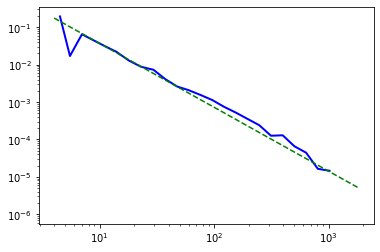

In [ ]:
import powerlaw # Power laws are probability distributions with the form:p(x)∝x−α
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
fit = powerlaw.Fit(degree_sequence)
fig2 = fit.plot_pdf(color='b', linewidth=2)
fit.power_law.plot_pdf(color='g', linestyle='--', ax=fig2)
R, p = fit.distribution_compare('power_law', 'lognormal')
print (R, p)

In [ ]:
## Find isolated nodes:
for i in nx.isolates(G):
    print(i)
# There are not isolated nodes
print("There are no isolated nodes")

There are no isolated nodes


In [ ]:
# Find Cycles
"""
D = nx.DiGraph([(0, 1), (2, 0), (1, 2),(2,1)])
cycle= nx.simple_cycles(G)
print(list(cycle))

cycle = pd.DataFrame(list(cycle))
print(cycle)
cycle.to_csv("../network/cycles.csv", sep='\t',index=False)
##for i in cycle:
#   print(i)
"""

'\nD = nx.DiGraph([(0, 1), (2, 0), (1, 2),(2,1)])\ncycle= nx.simple_cycles(G)\nprint(list(cycle))\n\ncycle = pd.DataFrame(list(cycle))\nprint(cycle)\ncycle.to_csv("../network/cycles.csv", sep=\'\t\',index=False)\n##for i in cycle:\n#   print(i)\n'

In [ ]:
#Find self loops
nx.number_of_selfloops(G)
for i in nx.selfloop_edges(G):
    print("There is one self loop which can be found at node:", i)

There is one self loop which can be found at node: (1931, 1931)


In [ ]:
#the source and target reference the index of the pd_nodes df
pd_edges[pd_edges["# source"]==1931]
#& pd_edges[" target"]==1931]]
#pd_nodes[pd_nodes["# index"]==1931]

,# source,target,distance,airline,airline_code,codeshare,equipment,stops
57358,1931,1930,352.862275,IL,10121,0,AT7,0
57359,1931,1589,673.949617,IL,10121,0,737,0
57360,1931,1590,214.215655,IL,10121,0,AT7 737,0
57361,1931,1931,0.000000,IL,10121,0,AT7,0
57362,1931,1942,544.646348,IL,10121,0,AT7,0
57363,1931,1925,495.988136,IL,10121,0,737 AT7,0
57364,1931,1941,534.399882,IL,10121,0,737,0


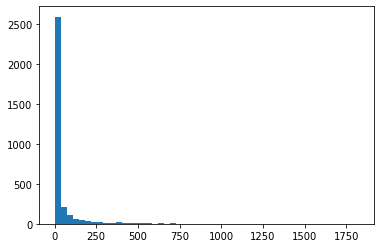

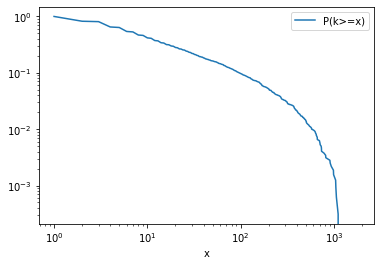

In [ ]:
# Degree distribution plot
def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees, 50)
    plt.show()

plot_degree_dist(G)
## THHE CCDF IS NOT DONE
# The cumulative distribution plot (The y-axis in a CCDF is the probability of finding a node of degree k or high)
def plot_cum_dist(G):
    degrees = [G.degree(n) for n in G.nodes()] #Is this the in or out degree? It is both
    num_of_nodes = len(degrees)
    count_degrees = Counter([G.degree(n) for n in G.nodes()])
    count_degrees = collections.OrderedDict(sorted(count_degrees.items()))
    cum_dict = {}
    node_count = 0
    for degree, times in count_degrees.items():
        node_count += times
        cum_dict[degree]= 1 - (node_count/num_of_nodes)
    data = pd.DataFrame(list(cum_dict.items()),columns = ['x','P(k>=x)'])
    data.plot(x = 'x',y = 'P(k>=x)', loglog = True)
    plt.show()

def from_book(G):
    dd = Counter(dict(G.degree).values())
    dd = pd.DataFrame(list(dd.items()), columns = ("k", "count")).sort_values(by = "k")
    ccdf = dd.sort_values(by = "k", ascending = False)
    ccdf["cumsum"] = ccdf["count"].cumsum()
    ccdf["ccdf"] = ccdf["cumsum"] / ccdf["count"].sum()
    ccdf = ccdf[["k", "ccdf"]].sort_values(by = "k")
    dd.plot(kind = "scatter", x = "k", y = "count", color = "#e41a1c")
    plt.show()

plot_cum_dist(G)

In [ ]:
#Density of the graph (Using networkx)
dens = nx.density(G)
print('Networkx density:', str(round(dens*100, 3))+'%')


#Density using the formular (simple directed graph)
# total egdes / total nodes*(total nodes - 1)
dens_form = (G.number_of_edges())/(G.number_of_nodes()*(G.number_of_nodes()-1))
print('Formular density:', str(round(dens_form*100, 3))+'%')


Networkx density: 0.647%
Formular density: 0.647%


In [ ]:
#Global clustestering coefficient
#here we are assuming that connection is all that matters, therefore digraph is used not multidigraph 
G_di = nx.DiGraph(G)
global_clustering = nx.transitivity(G_di)
global_clustering
# Local clustering
local_clustering = nx.clustering(G_di)
#Average clustering coefficient
avg_clustering = nx.average_clustering(G_di)

print("Global clustering:", global_clustering)
print("Average clustering:",avg_clustering)
print("Local clustering:",local_clustering)

Global clustering: 0.25005448521436646
Average clustering: 0.4782853255477227
Local clustering: {0: 1.0, 2: 0.390625, 3: 0.3888888888888889, 1: 0.5714285714285714, 4: 0.12298387096774194, 5: 0.8333333333333334, 2250: 0.7, 2256: 1.0, 2251: 1.0, 2254: 0.8333333333333334, 2253: 1.0, 2243: 0.6666666666666666, 2246: 1.0, 2245: 0.6666666666666666, 2255: 0.42857142857142855, 1610: 0.1276029434789416, 2244: 0.3333333333333333, 2247: 0.6666666666666666, 2241: 0.5, 2135: 0.15270935960591134, 2242: 0, 1612: 0.16646848989298454, 1951: 0.2537746806039489, 2048: 0.08319738988580751, 1485: 0.20884986225895316, 2248: 1.0, 2249: 0, 1115: 0.1575091575091575, 903: 0.20793950850661624, 1058: 0.23894731832675012, 1607: 0.17473118279569894, 1639: 0.1134456794550018, 2257: 0, 6: 0.3, 7: 0.17857142857142858, 2260: 1.0, 2261: 0.3333333333333333, 2264: 1.0, 8: 0.2857142857142857, 1988: 0.2, 2266: 0.6666666666666666, 2262: 1.0, 13: 0.4926644581164221, 14: 0, 295: 0.2964827610152425, 1989: 0.6666666666666666, 9: 

In [ ]:
diameters=[]
for i in (G.subgraph(c) for c in nx.strongly_connected_components(G)):
    diameters.append(nx.diameter(i))

KeyboardInterrupt: 

In [ ]:
#Path length distribution 
shortest = dict(nx.all_pairs_shortest_path_length(G))
#print(shortest)

In [ ]:
all_paths_len = []
for i in shortest.values():
    for x in i.values():
        all_paths_len.append(x)

In [ ]:
import statistics
print("Diameter: ",max(all_paths_len))
print("Av path length:",statistics.mean(all_paths_len))

Diameter:  13
Av path length: 3.984675772976349


In [ ]:
from math import log
count = Counter(all_paths_len)
plt.bar(count.keys(),[math.log(i+0.1) for i in count.values()])
plt.title("Log Frequencies of Path Lenghts")
plt.xlabel("Path Length")
plt.ylabel("Log Frequency")
plt.show()
print(count)


NameError: name 'math' is not defined

In [ ]:
print(nx.DiGraph(G))

DiGraph with 3214 nodes and 36907 edges


In [ ]:
# Closeness
nx.closeness_centrality(G)

{0: 0.224592339092669,
 2: 0.22467311027122494,
 3: 0.22467311027122494,
 1: 0.22464079482925858,
 4: 0.2907325253258415,
 5: 0.224592339092669,
 2250: 0.2246084886820192,
 2256: 0.2245761918254972,
 2251: 0.2245761918254972,
 2254: 0.2245761918254972,
 2253: 0.22456004688000292,
 2243: 0.2245761918254972,
 2246: 0.2245761918254972,
 2245: 0.224592339092669,
 2255: 0.22612062053719706,
 1610: 0.32970553642609673,
 2244: 0.224592339092669,
 2247: 0.2245761918254972,
 2241: 0.224592339092669,
 2135: 0.28752119404462817,
 2242: 0.22454390425568546,
 1612: 0.28818435760686784,
 1951: 0.30095676385979775,
 2048: 0.24955103076622517,
 1485: 0.3741322616002923,
 2248: 0.2245761918254972,
 2249: 0.22454390425568546,
 1115: 0.3341853270675982,
 903: 0.3035597912634442,
 1058: 0.3774323649227695,
 1607: 0.354796711960568,
 1639: 0.3389355742296919,
 2257: 0.22454390425568546,
 6: 0.21171412851435817,
 7: 0.24445376835974647,
 2260: 0.1959617473087102,
 2261: 0.1743486409969212,
 2264: 0.17432918

In [ ]:
#betweenness centrality
nx.betweenness_centrality(G)

NetworkXNotImplemented: not implemented for multigraph type

In [ ]:
#global reaching centality
nx.global_reaching_centrality(G)

0.015025811825577145

In [ ]:
#plane types explored 
from collections import Counter
equipment=[]
for i in pd_edges[" equipment"]:
    possible=str(i).split()
    for j in possible:
        equipment.append(j)
unique_equipment_count=Counter(equipment)
unique_equipment=pd.DataFrame(set(equipment))
print("Amount of each plane type",unique_equipment_count)
print("Unique plane types",set(equipment))
#print(Counter(pd_edges[" equipment"])) nope


Amount of each plane type Counter({'320': 15400, '738': 10344, '319': 7847, '321': 3662, '73H': 3343, '737': 2753, '73W': 2492, 'CRJ': 2224, 'E90': 1968, 'AT7': 1595, '333': 1585, '73G': 1584, '332': 1439, 'DH4': 1387, '733': 1283, '763': 1183, 'CR7': 1161, '757': 1069, 'CR9': 1011, 'ER4': 989, 'ERJ': 947, '777': 945, '77W': 908, '330': 903, '739': 868, 'E70': 864, 'DH8': 785, 'M88': 725, '735': 705, 'E75': 701, 'M80': 656, '772': 633, 'ATR': 626, '73C': 623, '717': 614, '752': 604, '744': 599, '100': 590, '343': 490, 'DH3': 484, 'SF3': 475, '767': 461, '734': 460, 'CR2': 458, 'E95': 457, 'M90': 416, 'ERD': 415, '32S': 383, '773': 370, '736': 364, 'M83': 361, 'DHT': 354, '32A': 315, '75W': 311, 'DH1': 305, 'BEH': 290, '788': 287, 'AT4': 269, 'CNA': 266, 'CNC': 258, 'AT5': 256, '318': 253, 'BE1': 237, '310': 225, '346': 222, '388': 214, 'EM2': 214, '76W': 196, 'EMJ': 195, 'DH2': 187, 'F70': 175, 'AR1': 162, 'M82': 160, 'CRK': 159, '764': 153, '77L': 151, '73J': 145, '753': 143, 'F50': 1

In [ ]:

unique_equipment.to_csv("./network/planes.csv", sep='\t',index=False)

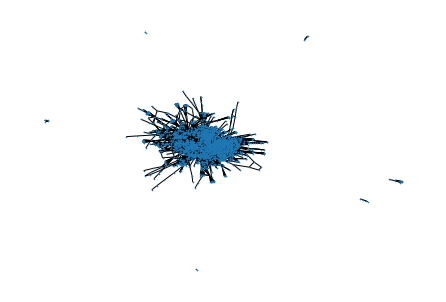

In [ ]:
nx.draw(G,node_size=0.4)
plt.show()

In [ ]:
!pip install python-igraph
!pip install powerlaw

     |████████████████████████████████| 3.3 MB 24.9 MB/s 


In [ ]:
import powerlaw # Power laws are probability distributions with the form:p(x)∝x−α
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)


NameError: name 'G' is not defined

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=30c69275-ad4c-4319-be77-065d0edffda8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>